<a href="https://colab.research.google.com/github/sudeepmenon17/PytorchforNN/blob/main/AirfoilS809_SAmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install google-auth

In [14]:
from google.colab import auth
from google.colab import drive

In [15]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
!ls /content/drive/MyDrive/ToSudeep3/ToSudeep3/

 Data_extraction_all.m	 data_set1.csv	 data_set3.csv	       'Re=1E6'
 Data_extraction_sep.m	 data_set2.csv	 neuralNetwork_reg.py  'Re=2E6'


In [17]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
# Create a Model class
class Model(nn.Module):
  def __init__(self,in_features=5, h1 = 61, h2 = 61, out_features=1):
    super().__init__()
    self.fc1 = nn.Linear(in_features,h1)
    self.fc2 = nn.Linear(h1,h2)
    # self.fc3 = nn.Linear(h2,h3)
    self.out = nn.Linear(h2,out_features)

  def forward(self,x):
    x = F.sigmoid(self.fc1(x))
    x = F.sigmoid(self.fc2(x))
    # x = F.sigmoid(self.fc3(x))
    x = self.out(x)

    return x

In [19]:
# torch.manual_seed(42)

model = Model()

In [20]:
# Read the data set - data_set3.csv --> Airfoil S809, Re = 2e6, alpha = 14.2 deg
df1 = pd.read_csv("/content/drive/MyDrive/ToSudeep3/ToSudeep3/data_set1.csv")
df2 = pd.read_csv("/content/drive/MyDrive/ToSudeep3/ToSudeep3/data_set2.csv")
df3 = pd.read_csv("/content/drive/MyDrive/ToSudeep3/ToSudeep3/data_set3.csv")


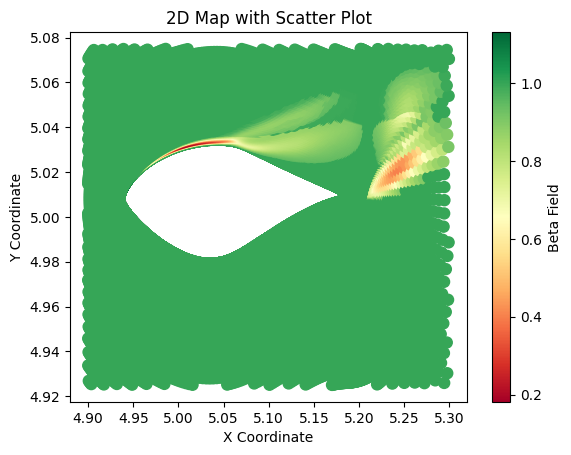

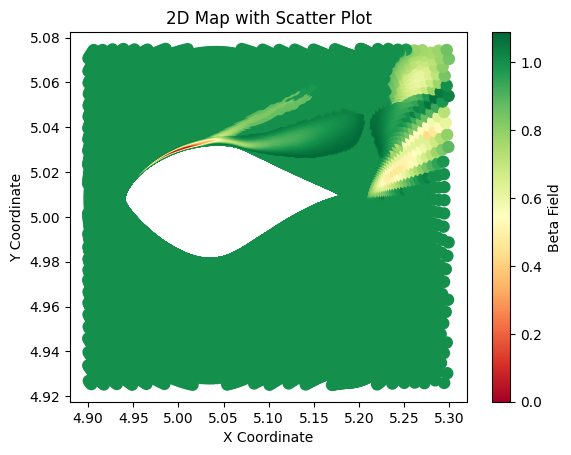

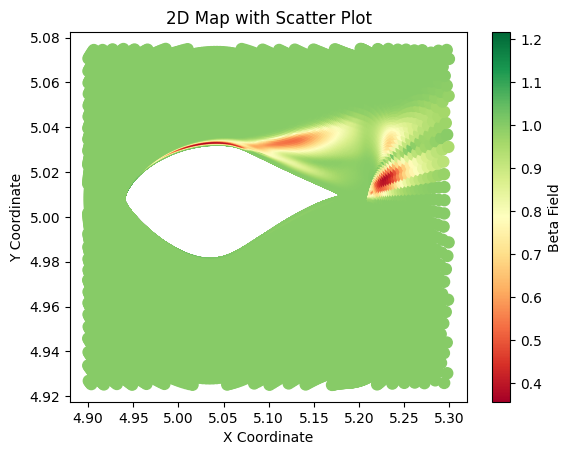

In [21]:
# Combine data
frames = [df1, df2, df3]
ff = []

for item in frames:
  xc = np.array(item['x'])
  yc = np.array(item['y'])
  b = np.array(item['beta'])
  b1 = []


  # Normalize x and y coordinates
  min_range = -5.0
  max_range = 5.0
  xc = (xc - np.min(xc)) * (max_range - min_range) / (np.max(xc) - np.min(xc))
  yc = (yc - np.min(yc)) * (max_range - min_range) / (np.max(yc) - np.min(yc))


  # #####################################################################
  # # Cleaning the beta field in the wake region
  # for k in range(len(xc)):
  #   if xc[k] >= 5.2 and xc[k] <= 5.3:
  #     if yc[k] >= 4.94 and yc[k] <= 4.96:
  #       b1.append(b[k])

  # for j in range(len(xc)):
  #   if xc[j] > 5.15 or yc[j]>5.04:
  #     b[j] = np.mean(b1)

  modified_data = {
    'x': np.array(xc),
    'y': np.array(yc),
    'beta': np.array(b),
    'feature1': np.array(item['feature1']),
    'feature2': np.array(item['feature2']),
    'feature3': np.array(item['feature3']),
    'feature4': np.array(item['feature4']),
    'feature5': np.array(item['feature5'])
  }

  item = pd.DataFrame(modified_data)

  ff.append(item)

  # #####################################################################
  # Plotting cleaned data
  ################################
  nx = []
  ny = []
  nb = []


  # Filter data for the specified range of coordinates
  for i in range(len(xc)):
    if xc[i]>=4.9 and xc[i]<=5.3:
      if yc[i]>=4.925 and yc[i]<=5.075:
        nx.append(xc[i])
        ny.append(yc[i])
        nb.append(b[i])

  # Create a scatter plot
  plt.scatter(nx, ny, c=nb,  cmap= 'RdYlGn',alpha=1, marker='.',s=250)
  plt.colorbar(label='Beta Field')
  plt.xlabel('X Coordinate')
  plt.ylabel('Y Coordinate')
  plt.title('2D Map with Scatter Plot')
  plt.show()
###############################################################################

df = pd.concat(ff)

# Data for beta>1.02 or beta<0.98
df_filtered = df[(df['beta'] > 1.005) | (df['beta'] < 0.995)]



In [22]:
from sklearn.preprocessing import StandardScaler



# Preprocess Features
df1 = df_filtered.drop(['x','y','beta'],axis=1)


# Fill missing values with the mean
df1 = df1.fillna(df1.mean())


# Standardization
standard_scaler = StandardScaler()

# Features
X = standard_scaler.fit_transform(df1)

# Target
y = df_filtered['beta'].values


In [23]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
# optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

In [24]:
#5-Fold Cross Validation
from sklearn import metrics

from sklearn.model_selection import KFold
kFold=KFold(n_splits=5,shuffle=True, random_state=100)

# Initialize a list to store the evaluation scores
scores = []
training_cost = []
testing_cost =[]
iterations = 100
train_fold = [[] for i in range(5)]
test_fold = [[] for i in range(5)]
c = 0
for train_index,test_index in kFold.split(X):
  print("Train Index: ", train_index, "\n")
  print("Test Index: ", test_index)
  print("Size of training data:", len(train_index),"\n")
  print("Size of testing data:", len(test_index),"\n")

  X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]


  X_train = torch.FloatTensor(X_train)
  X_test = torch.FloatTensor(X_test)

  y_train = torch.FloatTensor(y_train)
  y_test = torch.FloatTensor(y_test)


  losses = []
  for i in range(iterations):
    # go forward and predict
    y_pred = model.forward(X_train)

    # Measure the loss
    loss = criterion(y_pred,y_train)

    # Keep track of the losses
    losses.append(loss.detach().numpy())

    # print every 10 epoch
    if i % 10 == 0:
      print(f'iter: {i} and loss: {loss}')

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_fold[c].append(y_pred.detach().numpy())
  train_fold[c].append(y_train.detach().numpy())
  training_cost.append(losses)

  # Evaluate Model
  with torch.no_grad():
    y_eval = model.forward(X_test)
    test_loss = criterion(y_eval,y_test)
  test_fold[c].append(y_eval.detach().numpy())
  test_fold[c].append(y_test.detach().numpy())

  testing_cost.append(test_loss)
  scores.append(metrics.mean_squared_error(y_eval,y_test))
  print('MSEloss: {}'.format(testing_cost))
  print('MSE error: {}'.format(scores))

  c = c+1

Train Index:  [    0     2     4 ... 17898 17900 17901] 

Test Index:  [    1     3     8 ... 17893 17894 17899]
Size of training data: 14321 

Size of testing data: 3581 



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([14321])) that is different to the input size (torch.Size([14321, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


iter: 0 and loss: 0.5754080414772034
iter: 10 and loss: 0.04685770720243454
iter: 20 and loss: 0.061423204839229584
iter: 30 and loss: 0.036030445247888565
iter: 40 and loss: 0.03329236060380936
iter: 50 and loss: 0.031016314402222633
iter: 60 and loss: 0.030647920444607735
iter: 70 and loss: 0.03018276020884514
iter: 80 and loss: 0.03022955358028412
iter: 90 and loss: 0.030134093016386032


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3581])) that is different to the input size (torch.Size([3581, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([14321])) that is different to the input size (torch.Size([14321, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSEloss: [tensor(0.0312)]
MSE error: [0.031174436]
Train Index:  [    0     1     2 ... 17899 17900 17901] 

Test Index:  [   12    13    15 ... 17886 17896 17897]
Size of training data: 14321 

Size of testing data: 3581 

iter: 0 and loss: 0.03034115396440029
iter: 10 and loss: 0.03032822348177433
iter: 20 and loss: 0.030323898419737816
iter: 30 and loss: 0.03032342530786991
iter: 40 and loss: 0.030321933329105377
iter: 50 and loss: 0.03032102808356285
iter: 60 and loss: 0.030320407822728157
iter: 70 and loss: 0.03031984716653824
iter: 80 and loss: 0.03031937964260578
iter: 90 and loss: 0.03031899407505989


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3581])) that is different to the input size (torch.Size([3581, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([14322])) that is different to the input size (torch.Size([14322, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSEloss: [tensor(0.0312), tensor(0.0304)]
MSE error: [0.031174436, 0.030360827]
Train Index:  [    1     2     3 ... 17897 17899 17901] 

Test Index:  [    0     6    10 ... 17892 17898 17900]
Size of training data: 14322 

Size of testing data: 3580 

iter: 0 and loss: 0.030764926224946976
iter: 10 and loss: 0.030763868242502213
iter: 20 and loss: 0.03076351061463356
iter: 30 and loss: 0.030763350427150726
iter: 40 and loss: 0.03076319582760334
iter: 50 and loss: 0.03076305240392685
iter: 60 and loss: 0.0307629331946373
iter: 70 and loss: 0.03076283261179924
iter: 80 and loss: 0.030762748792767525
iter: 90 and loss: 0.030762670561671257


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3580])) that is different to the input size (torch.Size([3580, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([14322])) that is different to the input size (torch.Size([14322, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSEloss: [tensor(0.0312), tensor(0.0304), tensor(0.0286)]
MSE error: [0.031174436, 0.030360827, 0.028605958]
Train Index:  [    0     1     3 ... 17899 17900 17901] 

Test Index:  [    2     4     5 ... 17873 17888 17895]
Size of training data: 14322 

Size of testing data: 3580 

iter: 0 and loss: 0.030235206708312035
iter: 10 and loss: 0.030234811827540398
iter: 20 and loss: 0.030234651640057564
iter: 30 and loss: 0.030234578996896744
iter: 40 and loss: 0.030234528705477715
iter: 50 and loss: 0.03023448958992958
iter: 60 and loss: 0.030234457924962044
iter: 70 and loss: 0.030234429985284805
iter: 80 and loss: 0.030234407633543015
iter: 90 and loss: 0.030234387144446373


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3580])) that is different to the input size (torch.Size([3580, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([14322])) that is different to the input size (torch.Size([14322, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSEloss: [tensor(0.0312), tensor(0.0304), tensor(0.0286), tensor(0.0307)]
MSE error: [0.031174436, 0.030360827, 0.028605958, 0.030721499]
Train Index:  [    0     1     2 ... 17898 17899 17900] 

Test Index:  [   26    27    28 ... 17890 17891 17901]
Size of training data: 14322 

Size of testing data: 3580 

iter: 0 and loss: 0.03020278736948967
iter: 10 and loss: 0.03020206280052662
iter: 20 and loss: 0.030201803892850876
iter: 30 and loss: 0.030201714485883713
iter: 40 and loss: 0.030201680958271027
iter: 50 and loss: 0.030201666057109833
iter: 60 and loss: 0.030201653018593788
iter: 70 and loss: 0.03020164556801319
iter: 80 and loss: 0.030201641842722893
iter: 90 and loss: 0.030201636254787445
MSEloss: [tensor(0.0312), tensor(0.0304), tensor(0.0286), tensor(0.0307), tensor(0.0308)]
MSE error: [0.031174436, 0.030360827, 0.028605958, 0.030721499, 0.03085889]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3580])) that is different to the input size (torch.Size([3580, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Text(0.5, 0, 'Epoch')

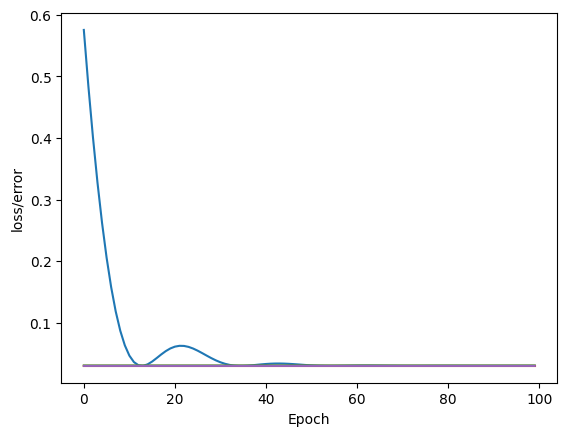

In [25]:
plt.plot(range(iterations), training_cost[0])
plt.plot(range(iterations), training_cost[1])
plt.plot(range(iterations), training_cost[2])
plt.plot(range(iterations), training_cost[3])
plt.plot(range(iterations), training_cost[4])
plt.ylabel("loss/error")
plt.xlabel('Epoch')

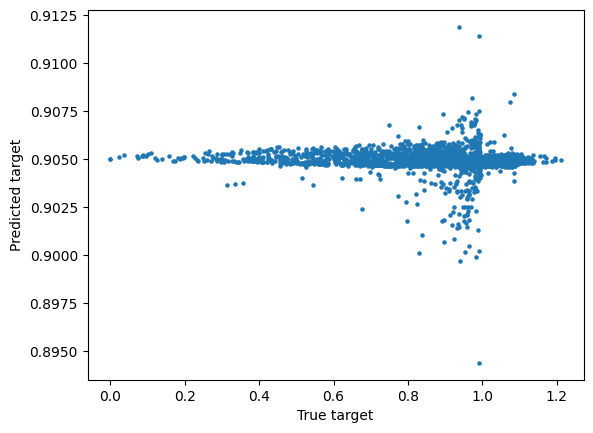

In [26]:
plt.scatter(test_fold[4][1],test_fold[4][0],s =5 )
# plt.scatter(train_fold[1][0],train_fold[1][1], s=5)
plt.xlabel('True')
plt.ylabel('Predicted')

plt.show()
